### Questions for Office Hours
- What should we do with the features that have versions (operating system version, linker version, etc.)?
- How should we go about encoding the DllCharacteristics feature since it is a flag?

Group members:
- Aya Abdelgawad
- Eric Ge
- Jay Acosta
- Vandana George

# The Problem
We will attempt to use classification algorithms to predict the presence of malicious code in a program. Having a relatively accurate classifier would be a great asset for antiviral protection, allowing users to protect their computers. This analysis in general would be fruitful for finding trends in compromised data and finding the most effective features to search for in order to classify code as suspicious.

The dataset we will be using was supplied by Max Secure Partner for a malware detection competition. It includes metadata on different programs that were labeled as either legitimate or not (contains malicious code). This metadata includes metrics such as the min/max/average entropy, the length of the code, flags it contains, and its hash.

In [41]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

%matplotlib inline

### Data Cleaning
In this section, we read in and the data and make sure it's all properly formatted.

In [89]:
# read in data using low_memory=False so it can properly read in the md5 hashes as strings
data = pd.read_csv('Kaggle-data.csv', low_memory=False)

# display description of all columns
pd.set_option('display.max_columns', None)
data.describe(include='all')

,ID,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,NumberOfRvaAndSizes,SectionsNb,SectionsMeanEntropy,SectionsMinEntropy,SectionsMaxEntropy,SectionsMeanRawsize,SectionsMinRawsize,SectionMaxRawsize,SectionsMeanVirtualsize,SectionsMinVirtualsize,SectionMaxVirtualsize,ImportsNbDLL,ImportsNb,ImportsNbOrdinal,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate,Unnamed: 57
count,216352.000000,216352,216352,216352.000000,216352.000000,216351.000000,216352.000000,2.163520e+05,2.163520e+05,2.163520e+05,2.163520e+05,2.163520e+05,2.163520e+05,2.163520e+05,2.163520e+05,216352.000000,216352.000000,216352.000000,216352.000000,216352.000000,216352.000000,216352.000000,2.163520e+05,2.163520e+05,2.163520e+05,216352.000000,216352.000000,2.163520e+05,2.163520e+05,2.163520e+05,2.163520e+05,2.163520e+05,2.163520e+05,216352.000000,216352.000000,216352.000000,216352.000000,2.163520e+05,2.163520e+05,2.163520e+05,2.163520e+05,2.163520e+05,2.163520e+05,216352.000000,216352.000000,216352.000000,216352.000000,216352.000000,216352.000000,216352.000000,216352.000000,2.163520e+05,2.163520e+05,2.163520e+05,2.163520e+05,216352.000000,216352.000000,1.0
unique,NaN,209329,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,9873531e6ba01adecf7e1e0f68c2df1a,332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,25,197618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,108176.500000,NaN,NaN,225.390197,4658.018849,9.052688,4.297964,3.953857e+05,5.827978e+05,1.332425e+06,2.812198e+05,9.263616e+04,2.597506e+05,6.825622e+14,8.973149e+03,876.249815,5.891214,1.908686,65.019649,62.194170,4.915735,1.062089,8.306375e+05,1.444321e+03,1.198387e+08,2.211697,19125.945395,8.226597e+07,8.135296e+07,1.375880e+06,4.596753e+04,9.237207e+04,6.160888e+04,4.907304,4.500140,2.046629,6.780452,1.623791e+05,1.908853e+04,5.588631e+05,1.824943e+05,2.066624e+04,6.279258e+05,7.375374,114.004788,4.702134,24.093205,21.311201,3.758643,2.391066,5.149387,9.997022e+04,7.139624e+04,2.524535e+05,1.023401e+06,7.888492,0.348982,0.0
std,62455.587057,NaN,NaN,4.559983,7843.855241,71.522478,11.965284,1.962775e+07,2.841106e+07,7.337809e+07,1.254327e+07,9.922827e+06,6.712844e+06,1.121701e+17,7.194441e+05,1362.854293,183.580174,227.045651,1163.764427,1153.224766,1.041145,144.727471,6.859762e+06,5.878291e+03,4.965103e+08,0.500514,16258.493510,3.782155e+10,3.782156e+10,1.478766e+08,7.974684e+06,1.370714e+07,1.242031e+07,2.554187,1.121715,1.825340,1.049097,6.451482e+06,3.186122e+05,2.573865e+07,3.393885e+06,3.189600e+05,1.073093e+07,727.966935,137.024438,36.612958,267.169003,130.677090,1.305126,1.042133,1.864471,1.718201e+07,1.681531e+07,2.433613e+07,4.772522e+07,8.049384,0.476649,NaN
min,1.000000,NaN,NaN,176.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.553600e+04,0.000000e+00,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

Looking at the description of our dataframe, we see two immediate columns that can be dropped: 'ID' (which is jus the row id) and 'Unnamed: 57' (which was likely created due to an error while reading in the csv data). Let's go ahead and get rid of those.

In [90]:
data = data.drop(columns=['ID', 'Unnamed: 57'])

Next, let's check the dataframe for NaNs.

In [82]:
# Check for NaNs
col_nans = data.isna().sum()
for i in range(len(col_nans)):
    if col_nans[i] > 0:
        print(f"{data.columns[i]} has {col_nans[i]} NaNs")

MajorLinkerVersion has 1 NaNs


In [ ]:
# TODO: 
# if gonna keep linker version feature, then drop the one row with a NaN
# drop Unnamed: 57
# convert hashes to numbers? (will be expensive to one-hot-encode)
# alternatively, could drop the hashes (every hash unique, and being similar to another hash doesn't mean inputs similar)

In [48]:
# Mapping values in Subsystem to their meaning - Subsystem will now be categorical

subsystem_keys = {
  0: "IMAGE_SUBSYSTEM_UNKNOWN",
  1: "IMAGE_SUBSYSTEM_NATIVE",
  2: "IMAGE_SUBSYSTEM_WINDOWS_GUI",
  3: "IMAGE_SUBSYSTEM_WINDOWS_CUI",
  5: "IMAGE_SUBSYSTEM_OS2_CUI",
  7: "IMAGE_SUBSYSTEM_POSIX_CUI",
  9: "IMAGE_SUBSYSTEM_WINDOWS_CE_GUI",
  10: "IMAGE_SUBSYSTEM_EFI_APPLICATION",
  11: "IMAGE_SUBSYSTEM_EFI_BOOT_SERVICE_DRIVER",
  12: "IMAGE_SUBSYSTEM_EFI_RUNTIME_DRIVER",
  13: "IMAGE_SUBSYSTEM_EFI_ROM",
  14: "IMAGE_SUBSYSTEM_XBOX",
  16: "IMAGE_SUBSYSTEM_WINDOWS_BOOT_APPLICATION"
}

# Removed DllCharacteristics for now
# dll_keys = {
#   1: "Reserved",
#   2: "Reserved",
#   4: "Reserved",
#   8: "Reserved",
#   0x20: "IMAGE_DLL_CHARACTERISTICS_HIGH_ENTROPY_VA",
#   0x40: "IMAGE_DLLCHARACTERISTICS_DYNAMIC_BASE",
#   0x80: "IMAGE_DLLCHARACTERISTICS_FORCE_INTEGRITY",
#   0x100: "IMAGE_DLLCHARACTERISTICS_NX_COMPAT",
#   0x200: "IMAGE_DLLCHARACTERISTICS_NO_ISOLATION",
#   0x400: "IMAGE_DLLCHARACTERISTICS_NO_SEH",
#   0x800: "IMAGE_DLLCHARACTERISTICS_NO_BIND",
#   0x1000: "IMAGE_DLL_CHARACTERISTICS_APPCONTAINER",
#   0x2000: "IMAGE_DLLCHARACTERISTICS_WDM_DRIVER",
#   0x4000: "IMAGE_DLL_CHARACTERISTICS_GUARD_CF",
#   0x8000: "IMAGE_DLLCHARACTERISTICS_TERMINAL_SERVER_AWARE"
# }

data['Subsystem'] = data['Subsystem'].replace(subsystem_keys)

data['Subsystem'].head()

0       IMAGE_SUBSYSTEM_WINDOWS_GUI
1    IMAGE_SUBSYSTEM_WINDOWS_CE_GUI
2       IMAGE_SUBSYSTEM_WINDOWS_GUI
3       IMAGE_SUBSYSTEM_WINDOWS_CUI
4       IMAGE_SUBSYSTEM_WINDOWS_CUI
Name: Subsystem, dtype: object

### Data Exploration
Time to create some visualizations to get a better understanding of our data!

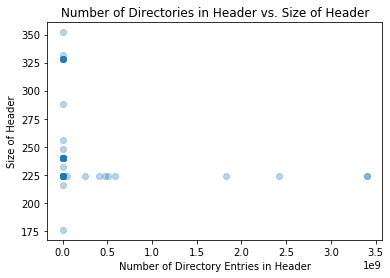

In [83]:
# In the optional header, all of the entries have a fixed size, except the last one, NumberOfRvaAndSizes
# NumberOfRvaAndSizes tells us how many directory entries are in the header
# SizeOfOptionalHeader gives the total size of the header
# Intuitively, these two variables are telling us very similar things 
# (how big is the whole thing vs. how big is it beyond some fixed size)
# Let's plot them and see if they are indeed strongly correlated

plt.scatter(data['NumberOfRvaAndSizes'], data['SizeOfOptionalHeader'], alpha=0.3)
plt.xlabel('Number of Directory Entries in Header')
plt.ylabel('Size of Header')
plt.title('Number of Directories in Header vs. Size of Header')
plt.show()

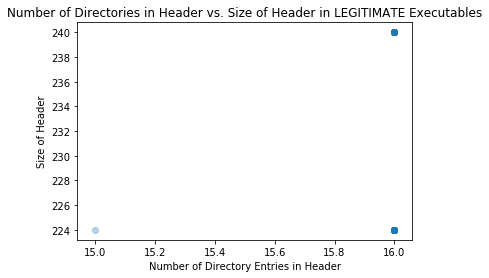

In [73]:
# The graph above is quite surprising, as it indicates there is no correlation when a strong one was expected
# Let's plot this graph for legit and malicious executables separately and see if there are any trends
legit = data[data['legitimate'] == 1]
plt.scatter(legit['NumberOfRvaAndSizes'], legit['SizeOfOptionalHeader'], alpha=0.3)
plt.xlabel('Number of Directory Entries in Header')
plt.ylabel('Size of Header')
plt.title('Number of Directories in Header vs. Size of Header in LEGITIMATE Executables')
plt.show()

# The plot below tells us that almost all legitimate executables in our dataset had 16 directory entries
# with header sizes of 224-240 bytes. Given that directories can be variable-sized, this variation is not
# surprising or alarming.

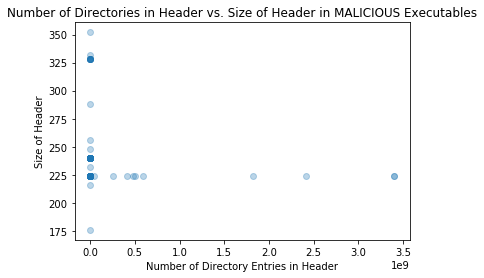

In [72]:
# Now let's try plotting those variables for our malicious records
not_legit = data[data['legitimate'] == 0]
plt.scatter(not_legit['NumberOfRvaAndSizes'], not_legit['SizeOfOptionalHeader'], alpha=0.3)
plt.xlabel('Number of Directory Entries in Header')
plt.ylabel('Size of Header')
plt.title('Number of Directories in Header vs. Size of Header in MALICIOUS Executables')
plt.show()

# The graph below strongly resembles the one where we included all our dataset, indicating that the odd behavior
# originates from our malicious records. Though these strange behaviors may not be all that frequent (the points'
# transparency was set to 30% to help show this), this trend is still helpful to keep in mind, as it indicates
# these features may be helpful for classification.

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1426: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


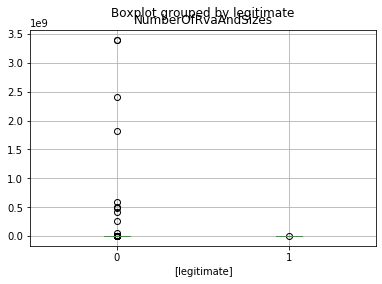

In [85]:
data.boxplot(column=['NumberOfRvaAndSizes'], by=['legitimate'])

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1426: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


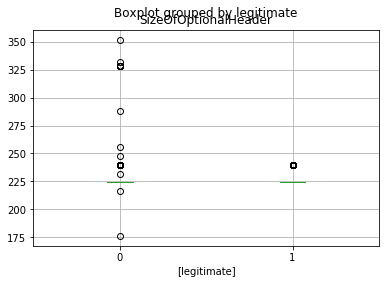

In [66]:
# plt.boxplot(data['SizeOfOptionalHeader'])
# plt.title('Boxplot of Header Sizes')
# plt.show()

data.boxplot(column=['SizeOfOptionalHeader'], by=['legitimate'])

### Feature Selection
In this section, we chose which features to drop based on their relevance to the problem of trying to detect malware.

~ More description will be added when getting closer to submission

In [91]:
# will get rid of the following for preliminary cleaning:
clean_out = ['Machine', 'Characteristics', 'MajorLinkerVersion', 'MinorLinkerVersion', 'BaseOfCode', 'MajorOperatingSystemVersion', 'MinorOperatingSystemVersion', 'MajorImageVersion', 'MinorImageVersion', 'SizeOfStackReserve', 'SizeOfStackCommit', 'SizeOfHeapReserve', 'SizeOfHeapCommit', 'LoaderFlags', 'NumberOfRvaAndSizes', 'DllCharacteristics']

# print out the number of features dropped
print ("Features dropped:", len (clean_out))

data.drop (columns=clean_out)

Features dropped: 16


,md5,SizeOfOptionalHeader,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,SectionsNb,SectionsMeanEntropy,SectionsMinEntropy,SectionsMaxEntropy,SectionsMeanRawsize,SectionsMinRawsize,SectionMaxRawsize,SectionsMeanVirtualsize,SectionsMinVirtualsize,SectionMaxVirtualsize,ImportsNbDLL,ImportsNb,ImportsNbOrdinal,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
0,b69acb3bb133974e48229627663f96d4,224,16896,8192,0,16947,24576,4194304.0,4096,512,5,1,40960,1024,84427,2,4,3.761598,2.446533,6.450720,6016.000000,1024,16896,6096.250000,960.0,16731,3,44,0,31,1,3.492126,3.492126,3.492126,864.000000,864.0,864,72,0,1
1,1cbee4b3725629bd0aa6ac2ff500925f,224,84480,25600,0,10973,90112,65536.0,4096,512,4,20,126976,1024,180181,9,5,4.973822,3.269968,6.504334,22016.000000,1024,84480,21902.800000,992.0,84410,2,102,100,2,1,3.486827,3.486827,3.486827,892.000000,892.0,892,72,0,1
2,b7027cf0cd31c820928950cbfe7e91ef,224,4608,3584,0,6452,12288,264962048.0,4096,512,6,0,24576,1024,10208,2,4,3.329824,0.278747,6.051986,1792.000000,512,4608,1708.000000,414.0,4294,2,27,0,3,1,3.517270,3.517270,3.517270,952.000000,952.0,952,72,0,1
3,156a0bb069f94d1e7c2508318805f2a4,224,108544,15872,0,105021,114688,268435456.0,4096,512,6,1,143360,1024,165754,3,5,3.404831,0.160329,6.662718,24883.200000,512,108544,25645.400000,85.0,108180,12,66,0,105,2,3.270559,3.034188,3.506931,1032.000000,972.0,1092,72,0,1
4,c72bf851fed5542abba904b1f3944cd5,224,513024,2048,0,520922,524288,268435456.0,8192,512,6,0,540672,512,582537,3,3,2.978056,0.101910,6.390683,171690.666667,512,513024,171265.333333,12.0,512736,1,1,0,0,1,3.420977,3.420977,3.420977,954.000000,954.0,954,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216347,8e292b418568d6e7b87f2a32aee7074b,224,205824,223744,0,123291,212992,4194304.0,4096,512,5,1,442368,1024,0,2,5,4.787797,2.247185,6.516364,84070.400000,7168,205824,85753.600000,16340.0,205644,7,133,0,0,7,4.122736,1.370260,7.677091,14900.714286,16.0,81654,72,0,0
216348,260d9e2258aed4c8a3bbd703ec895822,224,37888,185344,0,40000,45056,4194304.0,4096,512,4,0,253952,1024,0,2,8,2.256582,0.000000,6.562232,27904.000000,0,181248,28451.500000,8.0,180988,8,96,0,0,26,3.377663,2.031619,5.050074,6905.846154,44.0,67624,0,15,0
216349,8d088a51b7d225c9f5d11d239791ec3f,224,118272,380416,0,59610,122880,4194304.0,4096,512,5,1,516096,1024,515385,2,5,5.659426,4.217938,7.977423,99737.600000,9728,331264,101043.000000,9304.0,330808,6,107,0,0,22,6.825406,2.617026,7.990487,14981.909091,48.0,22648,72,14,0
216350,4286dccf67ca220fe67635388229a9f3,224,49152,16896,0,51216,53248,4194304.0,4096,512,4,0,90112,1024,0,2,8,3.012682,0.000000,6.431188,8256.000000,0,49152,8362.875000,12.0,48696,9,101,0,0,10,3.421627,2.060964,4.739744,601.600000,16.0,2216,0,0,0


In [16]:
# Checking the head of the data to check features
data.head()

,ID,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,NumberOfRvaAndSizes,SectionsNb,SectionsMeanEntropy,SectionsMinEntropy,SectionsMaxEntropy,SectionsMeanRawsize,SectionsMinRawsize,SectionMaxRawsize,SectionsMeanVirtualsize,SectionsMinVirtualsize,SectionMaxVirtualsize,ImportsNbDLL,ImportsNb,ImportsNbOrdinal,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate,Unnamed: 57
0,1,b69acb3bb133974e48229627663f96d4,332,224,8450,8.0,0,16896,8192,0,16947,4096,24576,4194304.0,4096,512,6,0,6,0,5,1,40960,1024,84427,2,320,262144,4096,1048576,4096,0,16,4,3.761598,2.446533,6.450720,6016.000000,1024,16896,6096.250000,960.0,16731,3,44,0,31,1,3.492126,3.492126,3.492126,864.0,864.0,864,72,0,1,NaN
1,2,1cbee4b3725629bd0aa6ac2ff500925f,332,224,258,9.0,0,84480,25600,0,10973,4096,90112,65536.0,4096,512,5,0,9,0,4,20,126976,1024,180181,9,320,65536,4096,1048576,4096,0,16,5,4.973822,3.269968,6.504334,22016.000000,1024,84480,21902.800000,992.0,84410,2,102,100,2,1,3.486827,3.486827,3.486827,892.0,892.0,892,72,0,1,NaN
2,3,b7027cf0cd31c820928950cbfe7e91ef,332,224,8450,8.0,0,4608,3584,0,6452,4096,12288,264962048.0,4096,512,6,0,6,0,6,0,24576,1024,10208,2,320,262144,4096,1048576,4096,0,16,4,3.329824,0.278747,6.051986,1792.000000,512,4608,1708.000000,414.0,4294,2,27,0,3,1,3.517270,3.517270,3.517270,952.0,952.0,952,72,0,1,NaN
3,4,156a0bb069f94d1e7c2508318805f2a4,332,224,8450,10.0,0,108544,15872,0,105021,4096,114688,268435456.0,4096,512,6,1,8,0,6,1,143360,1024,165754,3,320,1048576,4096,1048576,4096,0,16,5,3.404831,0.160329,6.662718,24883.200000,512,108544,25645.400000,85.0,108180,12,66,0,105,2,3.270559,3.034188,3.506931,1032.0,972.0,1092,72,0,1,NaN
4,5,c72bf851fed5542abba904b1f3944cd5,332,224,8226,48.0,0,513024,2048,0,520922,8192,524288,268435456.0,8192,512,4,0,0,0,6,0,540672,512,582537,3,34144,1048576,4096,1048576,4096,0,16,3,2.978056,0.101910,6.390683,171690.666667,512,513024,171265.333333,12.0,512736,1,1,0,0,1,3.420977,3.420977,3.420977,954.0,954.0,954,0,0,1,NaN
